In [1]:
import cv2
import numpy as np
from imutils import perspective
from imutils import contours
import numpy as np
import imutils
import cv2
import plotly
import plotly.express as px
import plotly.graph_objects as go
from skimage import data, filters, measure, morphology
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import seaborn as sns

In [406]:
#Initial attempt -- do not run!
imgs = np.load('images.npy')
n = 10
image = imgs[n]
img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
ground_tr = np.load('labels_3c.npy')[n]
instances = np.load('labels.npy')[n][:,:,0]
semantic = np.load('labels.npy')[n][:,:,1]

# In case ground truth is not available, otherwise: we intuitively multiply labels and images after setting boundaries and mask threshold equal to 0 
# threshold = filters.threshold_niblack(img * ground_tr) # Binary image, post-process the binary mask and compute labels 
# mask = morphology.remove_small_objects(mask, 50)
# mask = morphology.remove_small_holes(mask, 50)

threshold = 0
ground_tr[ground_tr == 2] = 0 
mask = img * ground_tr > threshold
labels = measure.label(mask, connectivity=1)

fig = px.imshow(image, binary_string=True)
fig.update_traces(hoverinfo='skip') # hover is only for label info

props = measure.regionprops(labels, img)
properties = ['area', 'eccentricity', 'perimeter', 'intensity_mean', 'orientation', 'axis_major_length', 'axis_minor_length']

# def contour_separation(contours):
#     c = np.expand_dims(contours.astype(np.float32), 1)
#     c = cv2.UMat(c)
#     area = cv2.contourArea(c)
#     return area
        
# For each label, we add a filled scatter trace for its contour and display the properties of the label in the hover of this trace.
contour, mod_cont = [], []
for index in range(labels.min(), labels.max()):
    label_i = props[index].label
    c = measure.find_contours(labels == label_i, 0.5)[0]
    # contour.append(c)
    # area = contour_separation(c)
    # if area <= 900:
    #     mod_cont.append(c)
    y, x = c.T
    hoverinfo = ''
    for prop_name in properties:
        hoverinfo += f'<b>{prop_name}: {getattr(props[index], prop_name):.2f}</b><br>'
    fig.add_trace(go.Scatter(
        x=x, y=y, name=label_i,
        mode='lines', fill='toself', marker_color = 'red',
        showlegend=False, hovertemplate=hoverinfo, hoveron='points+fills'))

# for index in range(0, len(mod_cont)):
#     y, x = mod_cont[index].T
#     hoverinfo = ''
#     for prop_name in properties:
#         hoverinfo += f'<b>{prop_name}: {getattr(props[index], prop_name):.2f}</b><br>'
#     fig.add_trace(go.Scatter(
#         x=x, y=y, name=label_i,
#         mode='lines', fill='toself', showlegend=False,
#         hovertemplate=hoverinfo, hoveron='points+fills'))
plotly.io.show(fig)

In [2]:
n = 200
class_color_mapping = {
    1: 'rgb(255, 165, 0)', # Orange
    2: 'rgb(0, 255, 0)',   # Green
    3: 'rgb(255, 0, 0)',   # Red
    4: 'rgb(0, 255, 255)', # Cyan
    5: 'rgb(0, 0, 255)',   # Blue
    6: 'rgb(255, 255, 0)', # Tellow
}
    
class_names = {
    1: 'Neutrophil',
    2: 'Epithelial',
    3: 'Lymphocyte',
    4: 'Plasma',
    5: 'Eosinophil',
    6: 'Connective',
}

imgs = np.load('images.npy')
image = imgs[n]
instances_map = np.load('labels.npy')[..., 0]
classification_map = np.load('labels.npy')[..., 1]
counts = pd.read_csv('counts.csv')

inst_map = instances_map[n]
unique_instances = np.unique(inst_map)[1:]
class_map = classification_map[n]

# Generating unique colours for each class associated with an instance
mask = inst_map != 0
instance_ids = inst_map[mask]
class_ids = class_map[mask]
instance_class_mapping = dict(zip(instance_ids, class_ids))
instance_class_sorted = {key:value for key, value in sorted(instance_class_mapping.items(), key=lambda item: int(item[0]))}

In [3]:
fig = px.imshow(image, binary_string=True)
fig.update_traces(hoverinfo='skip') 

properties = ['area', 'eccentricity', 'perimeter', 'orientation', 'axis_major_length', 'axis_minor_length', 'num_pixels']
istances_properties_table = measure.regionprops_table(inst_map, image, properties) #Total properties table

colors_used = {}
for instance_label in unique_instances:
    mask = np.where(inst_map == instance_label, 255, 0).astype(np.uint8) # Create a mask for the current instances
    contours = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[0] # Find contours in the mask
    props = measure.regionprops(mask, image, properties)[0] #Properties for each instance

    # Iterate through contours of the current instance
    for idx, contour in enumerate(contours):
        contour = np.squeeze(contour, axis=1) # Contour in plotly-compatible format
        y, x = contour[:, 1], contour[:, 0]
        
        hoverinfo = ''
        for prop_name in properties:
            hoverinfo += f'<b>{prop_name}:</b> {getattr(props, prop_name):.2f}<br>' #Hoverinfo text
        
        color = class_color_mapping.get(instance_class_mapping[instance_label])
        colors_used[instance_class_mapping[instance_label]] = color

        # Add trace for the contour
        fig.add_trace(go.Scatter(
            x=x, y=y, mode='lines', fill='toself',
            line=dict(color=color), 
            hoveron='points+fills',
            hovertemplate=hoverinfo,
            showlegend=False
        ))  
        
colors_used = dict((v1, v2) for k2,v2 in colors_used.items() for k1,v1 in class_names.items() if k1==k2)
      
for class_id, color in colors_used.items():
    fig.add_trace(go.Scatter(y=[None], mode='markers',
                         marker=dict(size=10, color=color[:3]+'a'+color[3:-1]+', 0.4)', line=dict(color=color, width=6)),
                         marker_symbol='diamond-wide', 
                         name=f"{class_id}",
                         ))

fig.update_layout(
    showlegend=True,
    legend=dict(
        x=0.73,
        y=0.7,
        traceorder="normal",
        title="",
        itemsizing="constant"
    ),
    # xaxis=dict(visible=False),
    # yaxis=dict(visible=False)
)

plotly.io.show(fig)

In [4]:
istances_properties_table['class'] = instance_class_mapping.values()
df = pd.DataFrame(istances_properties_table)
df

,area,eccentricity,perimeter,orientation,axis_major_length,axis_minor_length,num_pixels,class
0,110.0,0.898331,42.520815,1.412121,18.275141,8.028629,110,6
1,36.0,0.653769,19.899495,0.846570,7.783997,5.890105,36,2
2,53.0,0.842129,25.556349,0.814689,11.172955,6.025303,53,6
3,65.0,0.616902,27.313708,1.435769,10.252282,8.068953,65,6
4,44.0,0.637276,21.899495,-0.527306,8.511250,6.559073,44,3
...,...,...,...,...,...,...,...,...
110,32.0,0.921881,21.313708,0.707574,10.308473,3.994262,32,6
111,52.0,0.817836,25.071068,1.370508,10.697285,6.155772,52,2
112,68.0,0.598068,28.485281,-1.447611,10.387040,8.324645,68,2
113,97.0,0.865569,39.213203,0.798270,16.101175,8.063314,97,6


In [5]:
df.groupby('class', as_index=False).max()
df.groupby('class', as_index=False).min()
df.groupby('class', as_index=False).mean()

,class,area,eccentricity,perimeter,orientation,axis_major_length,axis_minor_length,num_pixels
0,2,108.571429,0.763909,38.149272,0.230796,15.477275,8.564302,108.571429
1,3,87.208333,0.747869,31.150511,0.065619,12.584786,7.674853,87.208333
2,4,103.181818,0.692874,33.370746,0.177839,12.760711,9.067081,103.181818
3,5,112.000000,0.608390,38.384776,-1.272418,13.632356,10.819162,112.000000
4,6,112.068182,0.748285,38.271393,0.231297,15.518511,8.563497,112.068182


In [6]:
'''
    To avoid the time-consuming wait for the loop, it is advisable to go to the next cell and load the npy file.
'''

instances_properties_all = {prop_name: [] for prop_name in properties} #Initialized properties table of whole dataset
instances_properties_all['instances'], instances_properties_all['class'] = [],[]

for idx in tqdm(range(0, len(imgs))):
    image = imgs[idx]
    inst_map = instances_map[idx]
    unique_instances = np.unique(inst_map)[1:]
    class_map = classification_map[idx]

    # Generating unique colours for each class associated with an instance
    mask = inst_map != 0
    instance_ids = inst_map[mask]
    class_ids = class_map[mask]
    instance_class_mapping = dict(zip(instance_ids, class_ids))
    instance_class_sorted = {key:value for key, value in sorted(instance_class_mapping.items(), key=lambda item: int(item[0]))}

    props_table = measure.regionprops_table(inst_map, image, properties)
    for prop_name in properties:
        instances_properties_all[prop_name].extend(props_table[prop_name])
        
    instances_properties_all['instances'].extend(np.arange(1, len(unique_instances)+1))
    instances_properties_all['class'].extend(instance_class_mapping.values())

# np.save('/Users/vguarin/Desktop/rendered_HE/instances_properties_tables.npy', instances_properties_all) #Uncomment to sae

  0%|          | 1/4981 [00:00<11:38,  7.13it/s]

100%|██████████| 4981/4981 [03:34<00:00, 23.27it/s] 


In [6]:
inst = np.load('/Users/vguarin/Desktop/rendered_HE/instances_properties_tables.npy', allow_pickle=True).item()
df_all = pd.DataFrame.from_dict(inst)

{1: 'Neutrophil', 2: 'Epithelial', 3: 'Lymphocyte', 4: 'Plasma', 5: 'Eosinophil', 6: 'Connective'}


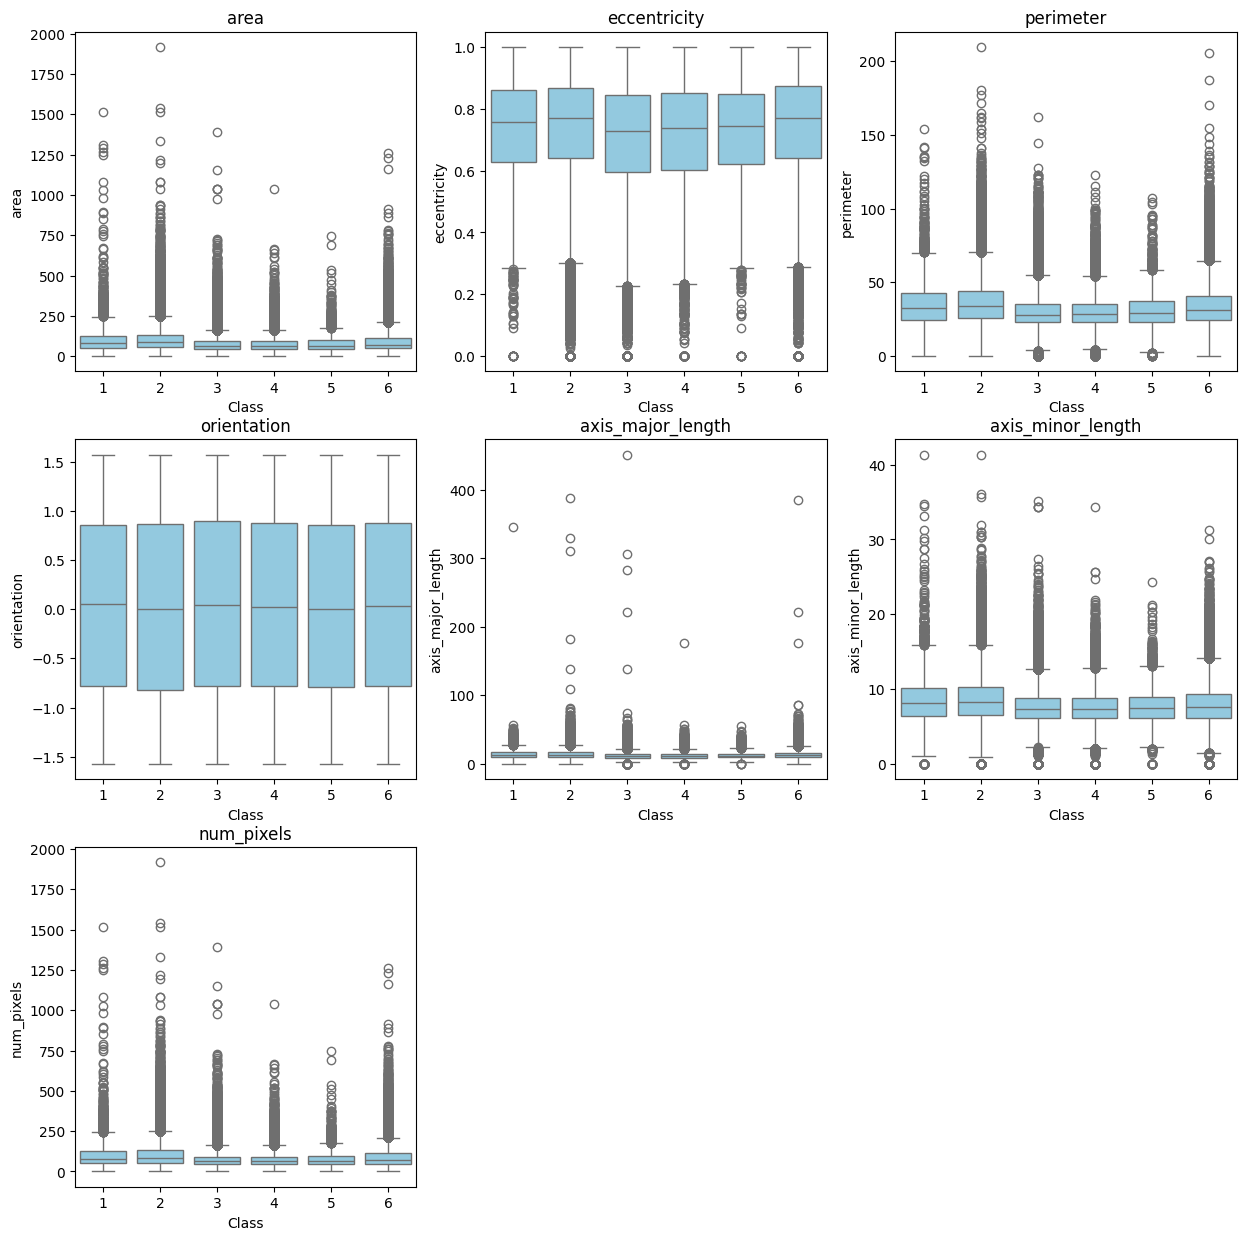

In [23]:
num_classes = len(df_all['class'].unique())
num_rows = len(properties) // 3
if len(properties) % 3 != 0:
    num_rows += 1
fig, axes = plt.subplots(num_rows, 3, figsize=(15, num_rows*5))

axes = axes.flatten()
for i, prop in enumerate(properties):
    # Plot boxplots for each property
    sns.boxplot(x='class', y=prop, data=df_all, ax=axes[i], color="skyblue")
    axes[i].set_title(prop)
    axes[i].set_xlabel('Class')
    axes[i].set_ylabel(prop)

for i in range(len(properties), len(axes)): # to hide empty subplots
    axes[i].axis('off')

print(class_names)

{1: 'Neutrophil', 2: 'Epithelial', 3: 'Lymphocyte', 4: 'Plasma', 5: 'Eosinophil', 6: 'Connective'}


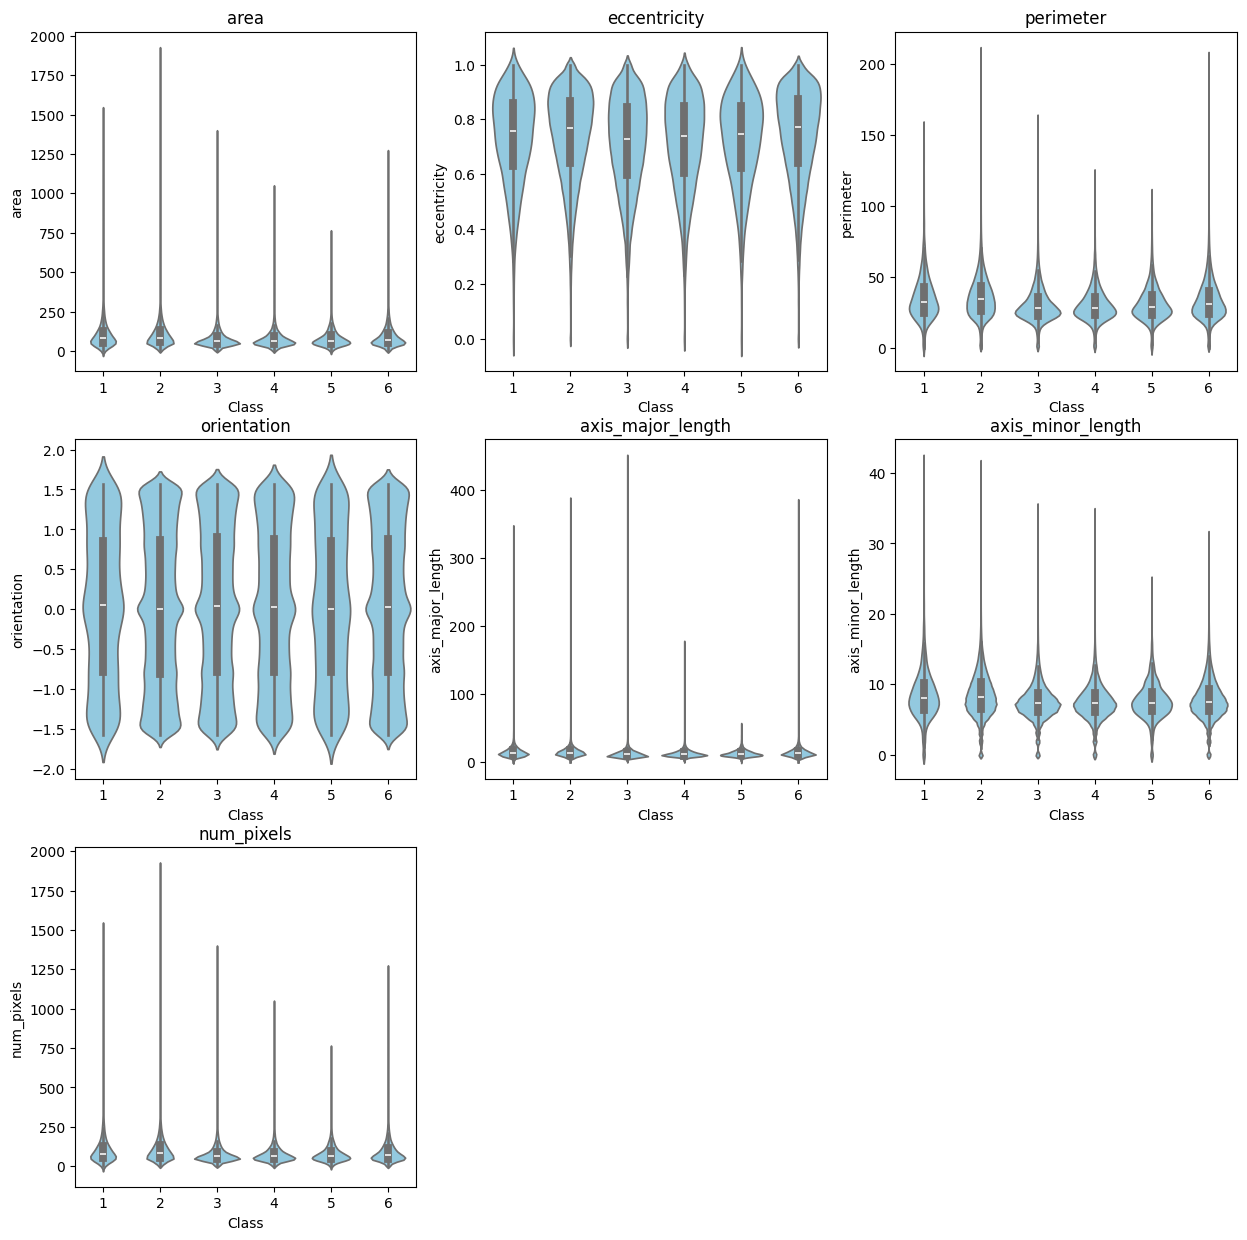

In [8]:
num_classes = len(df_all['class'].unique())
num_rows = len(properties) // 3
if len(properties) % 3 != 0:
    num_rows += 1
fig, axes = plt.subplots(num_rows, 3, figsize=(15, num_rows*5))

axes = axes.flatten()
for i, prop in enumerate(properties):
    # Plot boxplots for each property
    sns.violinplot(x='class', y=prop, data=df_all, ax=axes[i], color="skyblue")
    axes[i].set_title(prop)
    axes[i].set_xlabel('Class')
    axes[i].set_ylabel(prop)

for i in range(len(properties), len(axes)): # to hide empty subplots
    axes[i].axis('off')

print(class_names)

{1: 'Neutrophil', 2: 'Epithelial', 3: 'Lymphocyte', 4: 'Plasma', 5: 'Eosinophil', 6: 'Connective'}


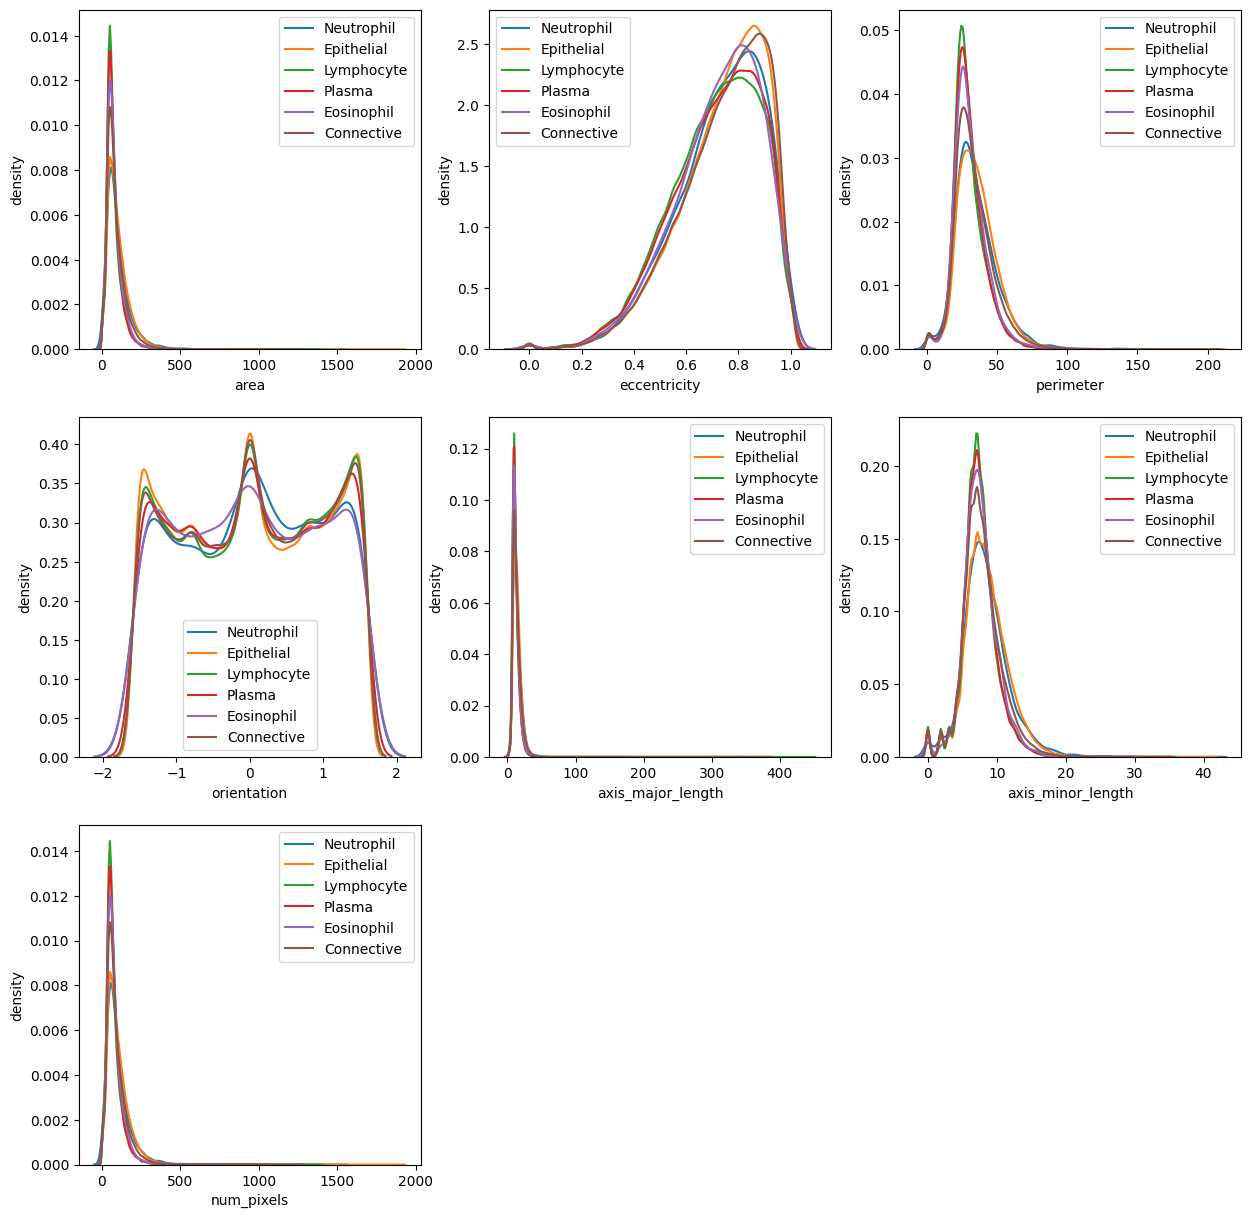

In [22]:
num_classes = len(df_all['class'].unique())
num_rows = len(properties) // 3
if len(properties) % 3 != 0:
    num_rows += 1
fig, axes = plt.subplots(num_rows, 3, figsize=(15, num_rows*5))

axes = axes.flatten()
for i, prop in enumerate(properties):
    # Plot boxplots for each property
    for class_label, data in df_all.groupby('class'):
            sns.kdeplot(data[prop], ax=axes[i], label=f'{class_names[class_label]}')    
    axes[i].set_xlabel(prop)
    axes[i].set_ylabel('density')
    axes[i].legend()

for i in range(len(properties), len(axes)): # to hide empty subplots
    axes[i].axis('off')    

print(class_names)

{1: 'Neutrophil', 2: 'Epithelial', 3: 'Lymphocyte', 4: 'Plasma', 5: 'Eosinophil', 6: 'Connective'}


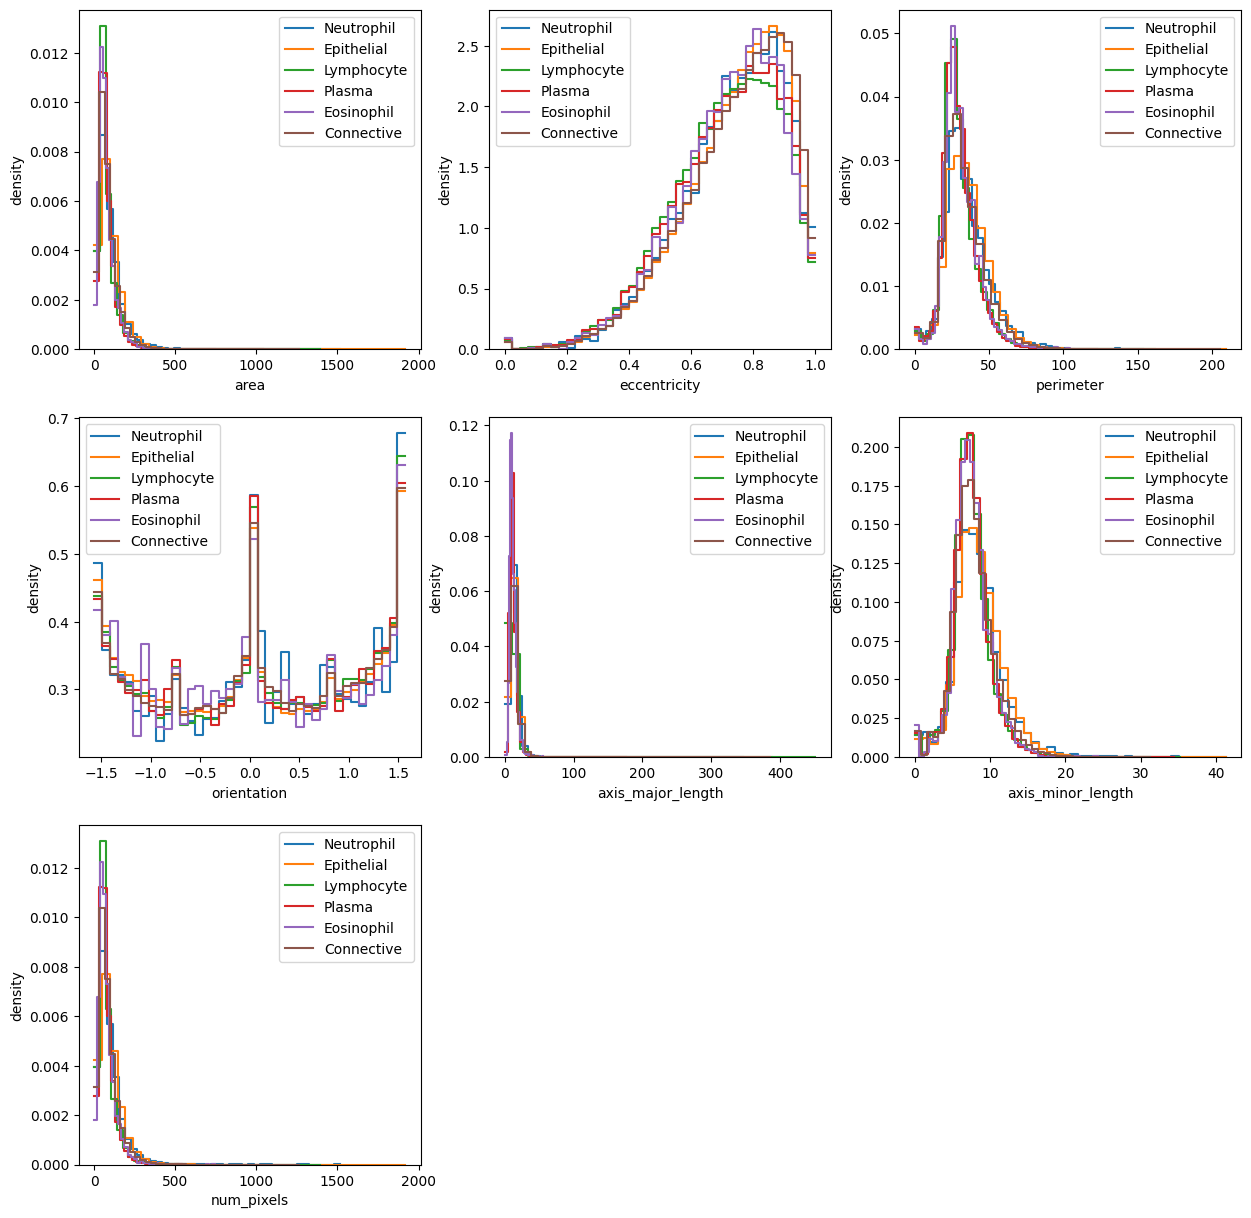

In [31]:
num_classes = len(df_all['class'].unique())
num_rows = len(properties) // 3
if len(properties) % 3 != 0:
    num_rows += 1
fig, axes = plt.subplots(num_rows, 3, figsize=(15, num_rows*5))

axes = axes.flatten()
for i, prop in enumerate(properties):
    # Plot boxplots for each property
    for class_label, data in df_all.groupby('class'):
        sns.histplot(data[prop], ax=axes[i], label=f'{class_names[class_label]}', kde=False, stat='density', common_norm=False, 
                     bins=40, element="step", fill=False) #edgecolor='None', alpha=0.3, 
    axes[i].set_xlabel(prop)
    axes[i].set_ylabel('density')
    axes[i].legend()

for i in range(len(properties), len(axes)): # to hide empty subplots
    axes[i].axis('off')    

print(class_names)

In [8]:
'''
   Counts from instance map as seen in: https://github.com/TissueImageAnalytics/CoNIC/blob/main/notebooks/data.ipynb
   
   We may notice that there exists more nuclei than in the original Lizard datset. 
   Although we mainly use non-overlapping patches, we choose to extract with overlap at the edge of each image to ensure 
   all pixels are considered without the need for padding.
'''

total_nuclei = 0
total_neutrophil = 0
total_epithelial = 0
total_lymphocyte = 0
total_plasma = 0
total_eosinophil = 0
total_connective = 0
total_list = [total_neutrophil, total_epithelial, total_lymphocyte, total_plasma, total_eosinophil, total_connective]
for idx in range(instances_map.shape[0]):
    patch_inst_map = instances_map[idx]
    patch_class_map = classification_map[idx]
    unique_vals = np.unique(patch_inst_map).tolist()[1:]
    total_nuclei += len(unique_vals)
    # get the counts per class
    for idx2 in range(6):
        patch_class_map_oneclass = patch_class_map == idx2+1
        # subset the instance map
        patch_inst_map_oneclass = patch_inst_map * patch_class_map_oneclass
        unique_vals = np.unique(patch_inst_map_oneclass).tolist()[1:]
        total_list[idx2] += len(unique_vals)

for idx, class_name in class_names.items():
    print(class_name, ":", total_list[idx-1])
    
print("Total :", total_nuclei)

Neutrophil : 5082
Epithelial : 282082
Lymphocyte : 120933
Plasma : 31965
Eosinophil : 3849
Connective : 125950
Total : 569861


In [10]:
'''
   Counts from counts.csv file as seen in: https://github.com/TissueImageAnalytics/CoNIC/blob/main/notebooks/data.ipynb
    
   We only consider the central 224x224 region for counting.
'''

counts_neutrophil = 0
counts_epithelial = 0
counts_lymphocyte = 0
counts_plasma = 0
counts_eosinophil = 0
counts_connective = 0
for idx in range(counts.shape[0]):
    counts_tmp = counts.iloc[idx]
    counts_neutrophil += counts_tmp['neutrophil']
    counts_epithelial += counts_tmp['epithelial']
    counts_lymphocyte += counts_tmp['lymphocyte']
    counts_plasma += counts_tmp['plasma']
    counts_eosinophil += counts_tmp['eosinophil']
    counts_connective += counts_tmp['connective']

counts_list = [counts_neutrophil, counts_epithelial, counts_lymphocyte, counts_plasma, counts_eosinophil, counts_connective]
for idx, count_type in enumerate(counts_list):
    print(class_names[idx+1], ":", count_type)
    
counts_total = sum(counts_list)
print("Total :", counts_total)

Neutrophil : 4012
Epithelial : 222017
Lymphocyte : 93612
Plasma : 24793
Eosinophil : 2999
Connective : 98783
Total : 446216


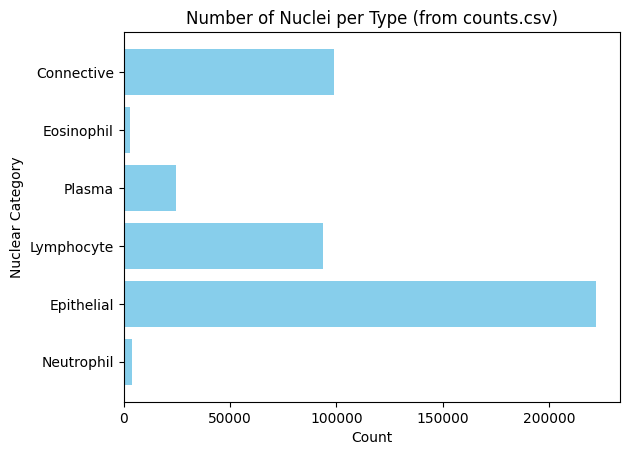

In [16]:
x_pos = [k for k, v in class_names.items()]

plt.barh(x_pos, counts_list, color="skyblue")
plt.xlabel("Count")
plt.ylabel("Nuclear Category")
plt.title("Number of Nuclei per Type (from counts.csv)")
plt.yticks(x_pos, class_names.values())
plt.show()